In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_centerlines = os.path.join(folder_HMA, 'Datasets', 'RGI', 'v7', 'L')
folder_centerlines = os.path.join(folder_HMA, 'Datasets', 'centerlines')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [4]:
# # open glacier centerline products
cl_gdf = gpd.read_file(os.path.join(folder_centerlines, 'FINAL_CENTERLINES.shp')) \
                .to_crs("ESRI:102025").drop(['layer', 'path', 'length'], axis=1)

In [5]:
# add the subregion as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"subregion"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["subregion","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["subregion","geometry"]])

In [6]:
# function that will identify the closest point in dfB for each point in dfA,
# attaching the corresponding distance value
def ckdnearest_dist(dfA, dfB):
    nA = np.array(dfA[['x','y']])
    nB = np.array(dfB[['x_p','y_p']])
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    dfB_nearest = dfB.iloc[idx].reset_index(drop=True)
    df = pd.concat(
        [
            dfA.reset_index(drop=True),
            dfB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)
    
    return df

# like above, but saving the value of the branch that it's in
def ckdnearest_branch(dfA, dfB):
    nA = np.array(dfA[['x','y']])
    nB = np.array(dfB[['x_p','y_p']])
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    dfB_nearest = dfB.iloc[idx].reset_index(drop=True)
    df = pd.concat(
        [
            dfA.reset_index(drop=True),
            dfB_nearest,
            pd.Series(dist, name='segment')
        ], 
        axis=1)
    
    return df

# function that will reverse the direction of the flowline, to make sure the start point is at the terminus
def reverse_geom(geom):
    def _reverse(x, y, z=None):
        if z:
            return x[::-1], y[::-1], z[::-1]
        return x[::-1], y[::-1]

    return shapely.ops.transform(_reverse, geom)

In [7]:
# for each row, open the glacier's mask, clip centerline products to that glacier
# but subset by region first, so we avoid constantly opening and closing the regional files
all_regions = np.sort(np.unique(rgi_gdf['subregion'].values))

# dc_gdf = dc_gdf[dc_gdf['rgi_id']=="RGI2000-v7.0-G-15-07878"]
c=0
for idx, row in dc_gdf.iterrows():
    c+=1
    # if c<270: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-13-28434": continue
    if c%10==1: print(c, "of", len(rgi_gdf), rgi_id)
    geom_save = row['geometry']
    
    # open glacier mask, debris mask
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
    xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)

    # subset centerlines to this glacier
    cl_g = cl_gdf[cl_gdf['rgi_g_id']==rgi_id]
    
    # grab the main glacier centerline, clip to debris-covered area
    cl_main = cl_g[cl_g['is_main']==1]
    main_flowline = shapely.intersection(reverse_geom(cl_main['geometry'].values[0]), row['geometry'].buffer(100))
    
    # create points equi-spaced along the line
    distances = np.arange(0, main_flowline.length, 20) 
    points = [main_flowline.interpolate(distance) for distance in distances] #+ [main_line.boundary[1]]
    
    # make into gdf and df
    points_gdf_main = gpd.GeoDataFrame(geometry=points)
    points_gdf_main['distance'] = distances
    df_points_main = pd.DataFrame({'y_p':[p.y for p in points_gdf_main['geometry']],
                              'x_p':[p.x for p in points_gdf_main['geometry']],
                              'distance': points_gdf_main['distance']})
    df_points_main['segment']=1

    
    # print(df_points_main.head(2))
    
    
    # repeat for any lines who outflow into this main segment
    lines_2 = cl_g[cl_g['outflow_id']==cl_main['segment_id'].values[0]]
    segments_extra = []
    
    segment_n = 2 # to track which glacier brnahc segment we're in
    extra_points = []
    for idx, row_l in lines_2.iterrows():
        fl = shapely.intersection(reverse_geom(row_l['geometry']), row['geometry'].buffer(100))
        if fl.length==0:continue

        # create points equi-spaced along the line
        distances_l = np.arange(0, fl.length, 20) 
        points_l = [fl.interpolate(distance) for distance in distances_l] #+ [main_line.boundary[1]]

        # make into gdf and df
        points_gdf_l = gpd.GeoDataFrame(geometry=points_l)
        points_gdf_l['distance'] = distances_l
        df_points_l = pd.DataFrame({'y_p':[p.y for p in points_gdf_l['geometry']],
                                  'x_p':[p.x for p in points_gdf_l['geometry']],
                                  'distance': points_gdf_l['distance']})
        
        # we need to find the closest point in the main centerline to this line
        p_1 = df_points_l[df_points_l['distance']==0]#
        p_1 = p_1.rename({'x_p':'x', 'y_p':'y'}, axis=1).drop('distance', axis=1)
        nearest = ckdnearest_dist(p_1, df_points_main)
        offset = nearest['distance'].values[0]
        df_points_l['distance'] = df_points_l['distance']+offset
        df_points_l['segment'] = segment_n
        extra_points.append(df_points_l)
        
        # take note of the segment_id so we can find other segments that flow into this one
        if row_l['segment_id'] not in segments_extra: segments_extra.append(row_l['segment_id'])
        segment_n += 1
       
    if len(extra_points)>0:
        extra_points = pd.concat(extra_points)
        all_points = pd.concat([df_points_main, extra_points])
        
    else:
        all_points = df_points_main
    
    ### one more time, go up one level of flowlines
    if len(segments_extra)>0:
        lines_3 = cl_g[cl_g['outflow_id'].isin(segments_extra)]

        extra_points = []
        for idx, row_l in lines_3.iterrows():
            # print(idx)
            fl = shapely.intersection(reverse_geom(row_l['geometry']), row['geometry'].buffer(100))
            if fl.length==0:continue

            # create points equi-spaced along the line
            distances_l = np.arange(0, fl.length, 20) 
            points_l = [fl.interpolate(distance) for distance in distances_l] #+ [main_line.boundary[1]]

            # make into gdf and df
            points_gdf_l = gpd.GeoDataFrame(geometry=points_l)
            points_gdf_l['distance'] = distances_l
            df_points_l = pd.DataFrame({'y_p':[p.y for p in points_gdf_l['geometry']],
                                      'x_p':[p.x for p in points_gdf_l['geometry']],
                                      'distance': points_gdf_l['distance']})

            # we need to find the closest point in the flowline that this one empties into
            p_1 = df_points_l[df_points_l['distance']==0]#
            p_1 = p_1.rename({'x_p':'x', 'y_p':'y'}, axis=1).drop('distance', axis=1)
            nearest = ckdnearest_dist(p_1, all_points)
            offset = nearest['distance'].values[0]
            df_points_l['distance'] = df_points_l['distance']+offset
            df_points_l['segment'] = segment_n
            extra_points.append(df_points_l)

            # take note of the segment_id so we can find other segments that flow into this one
            if row_l['segment_id'] not in segments_extra: segments_extra.append(row_l['segment_id'])
            segment_n += 1

        if len(extra_points)>0:
            extra_points = pd.concat(extra_points)
            all_points = pd.concat([all_points, extra_points])
        else:
            all_points = all_points
    
    
    
    
    
    # create a df from the glacier mask, with each point's x/y location
    df_glacier = xr_dmask.rename('mask').to_dataframe('mask').drop('spatial_ref', axis=1).reset_index()
    df_glacier_subset = df_glacier[df_glacier['mask']==1].drop('mask', axis=1)
    
    # calculate the nearest of the centerline points for each pixel on glacier surface
    nearest_neighbor_df = ckdnearest_dist(df_glacier_subset, all_points[['x_p','y_p','distance']])
    
    # find which segment of the glacier it belongs to
    segment_branch_df = ckdnearest_dist(df_glacier_subset, all_points[['x_p','y_p','segment']])
    
    #### distances
    # rejoin to df_glacier
    new_distance_df = pd.merge(df_glacier, nearest_neighbor_df,  how='left', on = ['x','y'])
    distances_xr = new_distance_df.set_index(['y','x']).to_xarray()['distance']
    distances_xr = distances_xr.interp_like(xr_dmask, method='nearest')
    
    out_xr = xr_dmask.copy()
    out_xr.values = distances_xr.values
    out_path = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_distances.tif')
    out_xr.rio.to_raster(out_path, compress='LZW', tiled=True)
    
    
    #### glacier segment
    # rejoin to df_glacier
    new_segment_df = pd.merge(df_glacier, segment_branch_df,  how='left', on = ['x','y'])
    segments_xr = new_segment_df.set_index(['y','x']).to_xarray()['segment']
    segments_xr = segments_xr.interp_like(xr_dmask, method='nearest')
    
    # save
    out_xr_segment = xr_dmask.copy()
    out_xr_segment.values = segments_xr.values
    out_path = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_glacier_branches.tif')
    out_xr_segment.rio.to_raster(out_path, compress='LZW', tiled=True)
    
print("Done")

1 of 769 RGI2000-v7.0-G-13-71546
11 of 769 RGI2000-v7.0-G-13-73737
21 of 769 RGI2000-v7.0-G-13-73613
31 of 769 RGI2000-v7.0-G-13-71566
41 of 769 RGI2000-v7.0-G-15-11613
51 of 769 RGI2000-v7.0-G-14-29482
61 of 769 RGI2000-v7.0-G-14-37501
71 of 769 RGI2000-v7.0-G-14-29742
81 of 769 RGI2000-v7.0-G-14-33219
91 of 769 RGI2000-v7.0-G-14-28030
101 of 769 RGI2000-v7.0-G-14-28047
111 of 769 RGI2000-v7.0-G-14-32751
121 of 769 RGI2000-v7.0-G-14-33124
131 of 769 RGI2000-v7.0-G-14-30697
141 of 769 RGI2000-v7.0-G-14-30402
151 of 769 RGI2000-v7.0-G-14-35588
161 of 769 RGI2000-v7.0-G-15-01643
171 of 769 RGI2000-v7.0-G-15-01285
181 of 769 RGI2000-v7.0-G-15-01785
191 of 769 RGI2000-v7.0-G-15-00910
201 of 769 RGI2000-v7.0-G-15-01699
211 of 769 RGI2000-v7.0-G-15-00762
221 of 769 RGI2000-v7.0-G-15-00710
231 of 769 RGI2000-v7.0-G-15-02547
241 of 769 RGI2000-v7.0-G-15-02613
251 of 769 RGI2000-v7.0-G-15-03505
261 of 769 RGI2000-v7.0-G-15-05101
271 of 769 RGI2000-v7.0-G-15-04980
281 of 769 RGI2000-v7.0-G-15-05

(-1704420.0, -1693290.0, 803370.0, 812610.0)

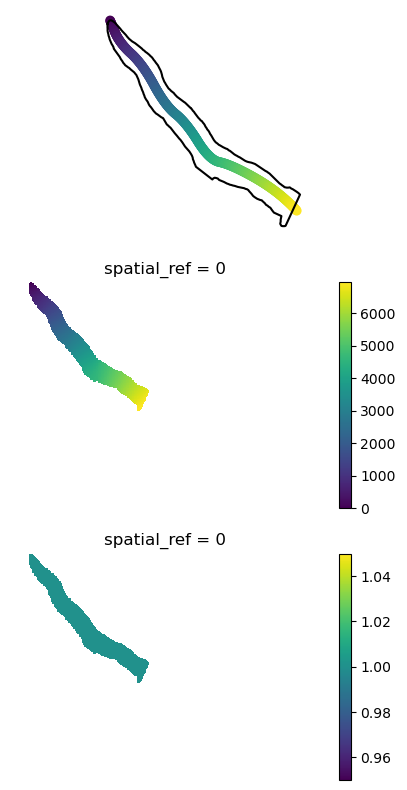

In [8]:
# lets plot the glacier outline and centerlines
fig,axs = plt.subplots(3,1, figsize=(5,10))

axs[0].plot(*geom_save.exterior.xy, c='black')

axs[0].scatter(all_points['x_p'], all_points['y_p'], c=all_points['distance'])
# points_gdf_main.plot(ax=axs[0], column='distance', vmin=0, vmax=np.nanmax(out_xr))

out_xr.plot(ax=axs[1])
out_xr_segment.plot(ax=axs[2])

axs[0].axis('equal')
axs[1].axis('equal')
axs[2].axis('equal')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')